In [ ]:
# https://www.kaggle.com/robottums/hybrid-recommender-systems-with-surprise

In [1]:
import surprise
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
raw=pd.read_csv('Data/ratings10k.csv')
raw.drop_duplicates(inplace=True)
print('we have',raw.shape[0], 'ratings')
print('the number of unique users we have is:', len(raw.user_id.unique()))
print('the number of unique books we have is:', len(raw.book_id.unique()))
print("The median user rated %d books."%raw.user_id.value_counts().median())
print('The max rating is: %d'%raw.rating.max(),"the min rating is: %d"%raw.rating.min())
raw.head()

we have 230595 ratings
the number of unique users we have is: 3788
the number of unique books we have is: 5743
The median user rated 57 books.
The max rating is: 5 the min rating is: 1


,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [3]:
raw=raw[['user_id','book_id','rating']] 
raw.columns = ['n_users','n_items','rating']

rawTrain,rawholdout = train_test_split(raw, test_size=0.25 )
# when importing from a DF, you only need to specify the scale of the ratings.
reader = surprise.Reader(rating_scale=(1,5)) 
#into surprise:
data = surprise.Dataset.load_from_df(rawTrain,reader)
holdout = surprise.Dataset.load_from_df(rawholdout,reader)

In [4]:
# check kaggle notebook for pseudocode and 4 chosen algorithms (research this for my own write up?)

In [5]:
# kSplit algo for collaborative filtering (code below uses KNN)
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # split data into folds. 

In [6]:
sim_options = sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
collabKNN = surprise.KNNBasic(k=40,sim_options=sim_options) #try removing sim_options. You'll find memory errors. 
rmseKNN = []
rmseSVD = []
rmseCo = []
rmseSlope = []
for trainset, testset in kSplit.split(data): #iterate through the folds.
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    rmseKNN.append(surprise.accuracy.rmse(predictionsKNN,verbose=True))#get root means squared error

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9432
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9377
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9356
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9422
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9301
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9190
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9370
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9336
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9334
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9313


In [7]:
# use Surprise's grid search CV to find best hyperparameters? find best algo (might not be KNNBasic)

In [9]:
# Simon Funk's Matrix Factorization Algorithm
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

In [10]:
min_error = 1
for trainset, testset in kSplit.split(data): #iterate through the folds.
    funkSVD.fit(trainset)
    predictionsSVD = funkSVD.test(testset)
    rmseSVD.append(surprise.accuracy.rmse(predictionsSVD,verbose=True))#get root means squared error

RMSE: 0.8855
RMSE: 0.8788
RMSE: 0.8770
RMSE: 0.8761
RMSE: 0.8952
RMSE: 0.8976
RMSE: 0.8931
RMSE: 0.8955
RMSE: 0.8916
RMSE: 0.8894


In [12]:
# Co-Clustering
coClus = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 
for trainset, testset in kSplit.split(data): #iterate through the folds.
    coClus.fit(trainset)
    predictionsCoClus = coClus.test(testset)
    rmseCo.append(surprise.accuracy.rmse(predictionsCoClus,verbose=True))#get root means squared error

RMSE: 0.9278
RMSE: 0.9170
RMSE: 0.9234
RMSE: 0.9293
RMSE: 0.9196
RMSE: 0.9298
RMSE: 0.9253
RMSE: 0.9232
RMSE: 0.9238
RMSE: 0.9239


In [14]:
# Slope One
slopeOne = surprise.prediction_algorithms.slope_one.SlopeOne()
for trainset, testset in kSplit.split(data): #iterate through the folds.
    slopeOne.fit(trainset)
    predictionsSlope = slopeOne.test(testset)
    rmseSlope.append(surprise.accuracy.rmse(predictionsSlope,verbose=True))#get root means squared error

RMSE: 0.8976
RMSE: 0.9063
RMSE: 0.9009
RMSE: 0.9023
RMSE: 0.9045
RMSE: 0.9014
RMSE: 0.9043
RMSE: 0.9022
RMSE: 0.9118
RMSE: 0.8977


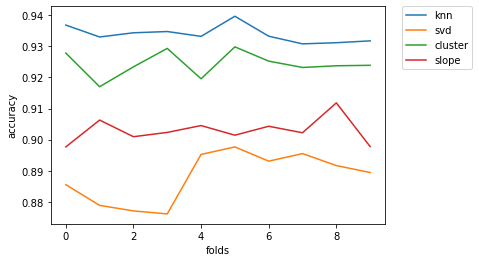

In [17]:
plt.plot(rmseKNN,label='knn') # KNNBasic
plt.plot(rmseSVD,label='svd') # Funk SVD
plt.plot(rmseCo,label='cluster') # Co-Clustering
plt.plot(rmseSlope,label='slope') # Slope One

plt.xlabel('folds')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)